## Step 1: Data Preprocessing

1. The MNIST dataset is loaded using `fetch_openml`, and only the digits `0` and `1` are used for binary classification.

2. The dataset is standardized with `StandardScaler` and split into training and test sets using `train_test_split`.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float64)
y = mnist.target.astype(int)

mask = (y == 0) | (y == 1)
X, y = X[mask], y[mask]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Step 2: Logistic Regression Functions

1. Sigmoid Function:

    Implements the sigmoid function.

2. Logistic Loss Function:

    Computes the negative log-likelihood loss.

3. Gradient Computation:

    Computes gradients and for the weights and bias to minimize the loss.

In [2]:
# Sigmoid function
def sigmoid(z):
    """
    Compute the sigmoid activation function.

    Parameters:
    - z (array-like): Input array.

    Returns:
    - (array-like): Output after applying the sigmoid function.
    """
    return 1 / (1 + np.exp(-z))

# Logistic loss function
def loss_function(w, b, X, y):
    """
    Compute binary cross-entropy loss.

    Parameters:
    - w (array-like): Weights.
    - b (float): Bias.
    - X (array-like): Input data.
    - y (array-like): Ground truth labels.

    Returns:
    - (float): Computed loss.
    """
    m = X.shape[0]
    z = np.dot(X, w) + b
    predictions = sigmoid(z)
    loss = -np.mean(y * np.log(predictions + 1e-15) + (1 - y) * np.log(1 - predictions + 1e-15))
    return loss

# Gradient computation
def compute_gradients(w, b, X, y):
    """
    Compute gradients for weights and bias.

    Parameters:
    - w (array-like): Weights.
    - b (float): Bias.
    - X (array-like): Input data.
    - y (array-like): Ground truth labels.

    Returns:
    - dw (array-like): Gradient of weights.
    - db (float): Gradient of bias.
    """
    m = X.shape[0]
    z = np.dot(X, w) + b
    predictions = sigmoid(z)
    error = predictions - y

    dw = np.dot(X.T, error) / m
    db = np.sum(error) / m

    return dw, db


## Step 3: Fletcher-Reeves Method

* Implements the Fletcher-Reeves nonlinear conjugate gradient method for optimization.

* Uses backtracking line search to determine the step size αα.

* Tracks the loss and gradient norms over iterations for analysis.

* Stops when the gradient norm is below the tolerance (`tol`) or the maximum number of iterations is reached.

In [19]:
# Fletcher-Reeves nonlinear conjugate gradient method
def fletcher_reeves(X, y, tol=1e-6, max_iter=100):
    """
    Optimize logistic regression using Fletcher-Reeves method.

    Parameters:
    - X (array-like): Input data.
    - y (array-like): Ground truth labels.
    - tol (float): Tolerance for stopping criterion.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - w (array-like): Optimized weights.
    - b (float): Optimized bias.
    - losses (list): Loss progression over iterations.
    - grad_norms (list): Gradient norm progression over iterations.
    """
    m, n = X.shape
    w = np.zeros(n)
    b = 0

    dw, db = compute_gradients(w, b, X, y)
    d = -dw

    losses = [loss_function(w, b, X, y)]
    grad_norms = [np.linalg.norm(dw)]

    for i in range(max_iter):
        alpha = backtracking_line_search(w, b, X, y, dw, db)

        w_new = w + alpha * d
        b_new = b - alpha * db

        dw_new, db_new = compute_gradients(w_new, b_new, X, y)

        beta = np.dot(dw_new, dw_new) / (np.dot(dw, dw) + 1e-10)
        d = -dw_new + beta * d

        w, b = w_new, b_new
        dw, db = dw_new, db_new

        losses.append(loss_function(w, b, X, y))
        grad_norms.append(np.linalg.norm(dw))

        if np.linalg.norm(dw) < tol:
            break

    return w, b, losses, grad_norms


## Step 4: Polak-Ribiere Method

* Implements the Polak-Ribiere nonlinear conjugate gradient method.

* Similar to Fletcher-Reeves but updates the search direction using a different formula for β

* Tracks loss and gradient norms over iterations.

* Stops based on gradient norm or maximum iterations.

In [20]:
# Polak-Ribiere nonlinear conjugate gradient method
def polak_ribiere(X, y, tol=1e-6, max_iter=100):
    """
    Optimize logistic regression using Polak-Ribiere method.

    Parameters:
    - X (array-like): Input data.
    - y (array-like): Ground truth labels.
    - tol (float): Tolerance for stopping criterion.
    - max_iter (int): Maximum number of iterations.

    Returns:
    - w (array-like): Optimized weights.
    - b (float): Optimized bias.
    - losses (list): Loss progression over iterations.
    - grad_norms (list): Gradient norm progression over iterations.
    """
    m, n = X.shape
    w = np.zeros(n)
    b = 0

    dw, db = compute_gradients(w, b, X, y)
    d = -dw

    losses = [loss_function(w, b, X, y)]
    grad_norms = [np.linalg.norm(dw)]

    for i in range(max_iter):
        alpha = backtracking_line_search(w, b, X, y, dw, db)

        w_new = w + alpha * d
        b_new = b - alpha * db

        dw_new, db_new = compute_gradients(w_new, b_new, X, y)

        beta = max(0, np.dot(dw_new, dw_new - dw) / (np.dot(dw, dw) + 1e-10))
        d = -dw_new + beta * d

        w, b = w_new, b_new
        dw, db = dw_new, db_new

        losses.append(loss_function(w, b, X, y))
        grad_norms.append(np.linalg.norm(dw))

        if np.linalg.norm(dw) < tol:
            break

    return w, b, losses, grad_norms


## Step 5: L-BFGS Method

* Implements the L-BFGS optimization method:

    * Uses limited memory for approximating the inverse Hessian matrix.
    
    * Stores past updates of weights and gradients to compute search directions.

* Includes a line search to determine the step size.

* Tracks loss and gradient norms for analysis.

In [21]:
def lbfgs_b(X, y, initial_alpha, tol=1e-6, max_iter=100, m=10, bounds=None):
    """
    Optimize a logistic regression model using the Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS) algorithm with backtracking line search.

    Parameters:
    - X (ndarray): Input data matrix of shape (n_samples, n_features).
    - y (ndarray): Ground truth labels vector of shape (n_samples,).
    - initial_alpha (float): Initial step size for backtracking line search.
    - tol (float, optional): Tolerance for convergence based on gradient norm. Default is 1e-6.
    - max_iter (int, optional): Maximum number of iterations. Default is 100.
    - m (int, optional): Memory size for storing past updates of weights and gradients for approximating the inverse Hessian. Default is 10.
    - bounds (tuple or None, optional): Bounds for weights (lower_bound, upper_bound). Default is None (no bounds applied).

    Returns:
    - w (ndarray): Optimized weights of shape (n_features,).
    - b (float): Optimized bias term.
    - losses (list): List of loss values over iterations.
    - grad_norms (list): List of gradient norms over iterations.

    Notes:
    - This implementation approximates the inverse Hessian matrix using a limited-memory scheme based on past updates.
    - A backtracking line search determines the step size to ensure sufficient decrease in loss.
    - The optimization stops when the gradient norm is below the specified tolerance or when the maximum number of iterations is reached.
    - The two-loop recursion efficiently computes the search direction without explicitly forming the Hessian matrix.

    Steps:
    1. Initialize weights `w` and bias `b` to zeros.
    2. Use the gradient and the loss function to iteratively update weights and bias.
    3. Employ the two-loop recursion to compute the search direction based on the past `m` updates.
    4. Adjust the step size dynamically using backtracking line search.
    5. Update weights and bias until convergence criteria are met or the maximum number of iterations is reached.

    """
    
    n = X.shape[1]
    w = np.zeros(n)  # Initialize weights
    b = 0           # Initialize bias

    s_list = []  # Stores the difference in weights
    y_list = []  # Stores the difference in gradients

    losses = [loss_function(w, b, X, y)]
    grad_norms = []

    for k in range(max_iter):
        dw, db = compute_gradients(w, b, X, y)
        grad = np.concatenate([dw, [db]])
        grad_norms.append(np.linalg.norm(grad))

        if np.linalg.norm(grad) < tol:
            break

        # Two-loop recursion for approximate inverse Hessian
        q = grad
        alphas = []
        for i in reversed(range(len(s_list))):
            s = s_list[i]
            y_ = y_list[i]
            rho = 1.0 / (np.dot(y_, s) + 1e-10)
            alpha = rho * np.dot(s, q)
            alphas.append(alpha)
            q = q - alpha * y_

        if len(s_list) > 0:
            gamma = np.dot(s_list[-1], y_list[-1]) / (np.dot(y_list[-1], y_list[-1]) + 1e-10)
        else:
            gamma = 1.0

        r = q * gamma

        for i in range(len(s_list)):
            s = s_list[i]
            y_ = y_list[i]
            rho = 1.0 / (np.dot(y_, s) + 1e-10)
            beta = rho * np.dot(y_, r)
            r = r + s * (alphas[len(s_list) - 1 - i] - beta)

        p = -r  # Search direction
        dw_update = p[:-1]
        db_update = p[-1]

        # Backtracking Line search
        alpha = initial_alpha
        while True:
            w_new = w + alpha * dw_update
            b_new = b + alpha * db_update

            if bounds is not None:
                w_new = np.clip(w_new, bounds[0], bounds[1])

            new_loss = loss_function(w_new, b_new, X, y)
            if new_loss < loss_function(w, b, X, y):
                break

            alpha *= 0.5

        s = np.concatenate([w_new - w, [b_new - b]])
        grad_new_dw, grad_new_db = compute_gradients(w_new, b_new, X, y)
        grad_new = np.concatenate([grad_new_dw, [grad_new_db]])
        y_ = grad_new - grad

        if len(s_list) == m:
            s_list.pop(0)
            y_list.pop(0)

        s_list.append(s)
        y_list.append(y_)

        w, b = w_new, b_new

        losses.append(loss_function(w, b, X, y))

    return w, b, losses, grad_norms


## Step 6: Prediction and Accuracy

1. Prediction:

    * Uses the logistic regression model to predict class labels based on the sigmoid output.

2. Accuracy:

    * Computes the classification accuracy as the fraction of correctly predicted labels.

In [22]:
# Prediction and accuracy
def predict(w, b, X):
    """
    Predict binary class labels.

    Parameters:
    - w (array-like): Weights.
    - b (float): Bias.
    - X (array-like): Input data.

    Returns:
    - (array-like): Predicted class labels.
    """
    z = np.dot(X, w) + b
    predictions = sigmoid(z)
    return (predictions >= 0.5).astype(int)

def accuracy(y_true, y_pred):
    """
    Compute classification accuracy.

    Parameters:
    - y_true (array-like): Ground truth labels.
    - y_pred (array-like): Predicted labels.

    Returns:
    - (float): Accuracy score.
    """
    return np.mean(y_true == y_pred)
    

## Step 7: Plotting Results

* Defines a function to plot:

    1. Loss progression over iterations.
    
    2. Gradient norm progression over iterations.


* Creates a side-by-side plot for visual comparison.

In [23]:
# Plotting Results
def plot_results(method_name, losses, grad_norms):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(losses, label="Loss")
    plt.title(f"{method_name}: Loss Progression")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.grid(True)

    # Gradient norm plot
    plt.subplot(1, 2, 2)
    plt.plot(grad_norms, label="Gradient Norm")
    plt.title(f"{method_name}: Gradient Norm Progression")
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Norm")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


## Step 8: Training and Comparison

1. Different Initial Step Sizes (α0​):

    * Tests the models (Fletcher-Reeves, Polak-Ribiere, and L-BFGS) with different initial step sizes (α0​=0.1,0.5,1.0,5.0).

2. Training Each Method:

    * Tracks training time, final loss, and accuracy for each optimization method.
    
    * Plots the loss and gradient norm progression for each method.

3. Backtracking Line Search:

    * Dynamically adjusts α during training based on the backtracking condition.


Using initial alpha: 0.1
Training using Fletcher-Reeves:
Fletcher-Reeves Train Loss: 0.0013340466207585008
Fletcher-Reeves Test Accuracy: 0.9993234100135318
Time taken: 2.7548 seconds


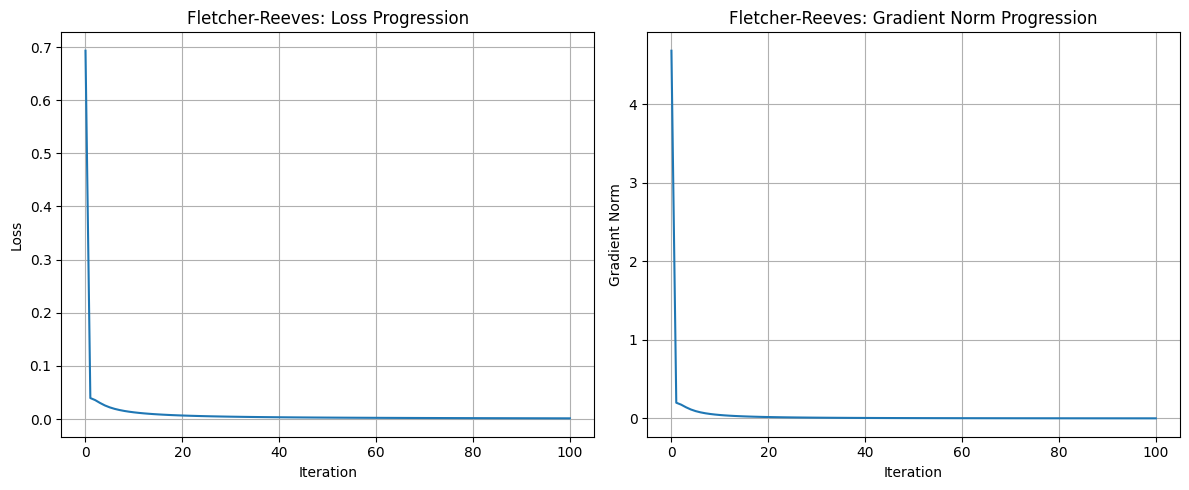


Training using Polak-Ribiere:
Polak-Ribiere Train Loss: 0.0067376582049361805
Polak-Ribiere Test Accuracy: 0.9989851150202977
Time taken: 2.5329 seconds


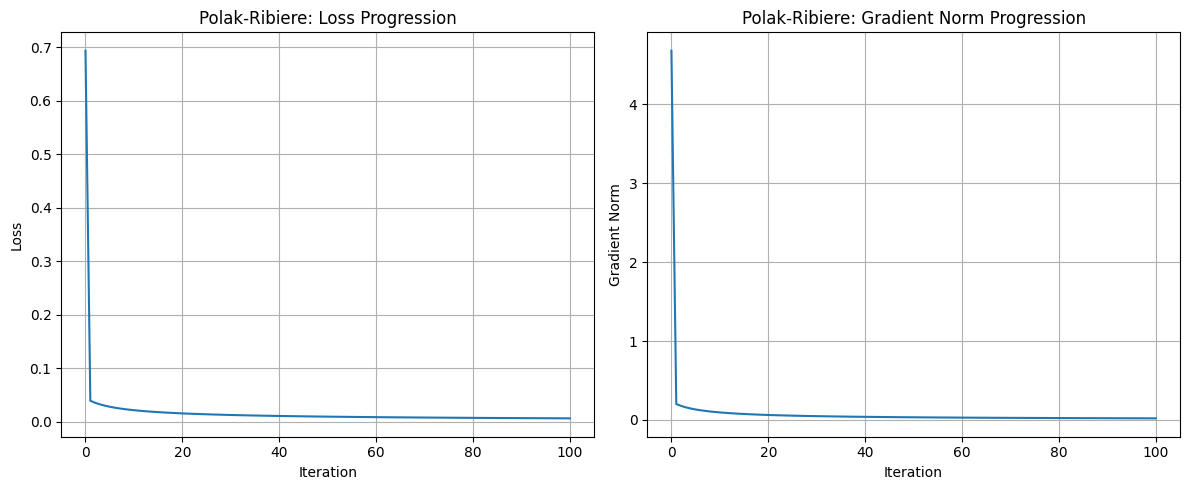


Training using L-BFGS:
L-BFGS Train Loss: 5.144374404065251e-06
L-BFGS Test Accuracy: 0.9993234100135318
Time taken: 3.3964 seconds


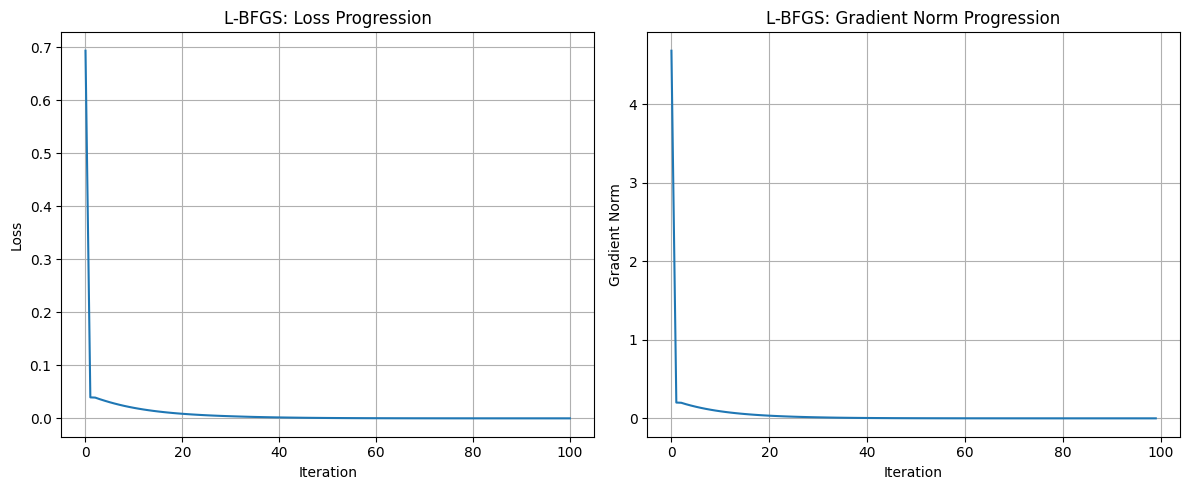


Using initial alpha: 0.5
Training using Fletcher-Reeves:
Fletcher-Reeves Train Loss: 0.00036244938558052247
Fletcher-Reeves Test Accuracy: 0.9986468200270636
Time taken: 2.5652 seconds


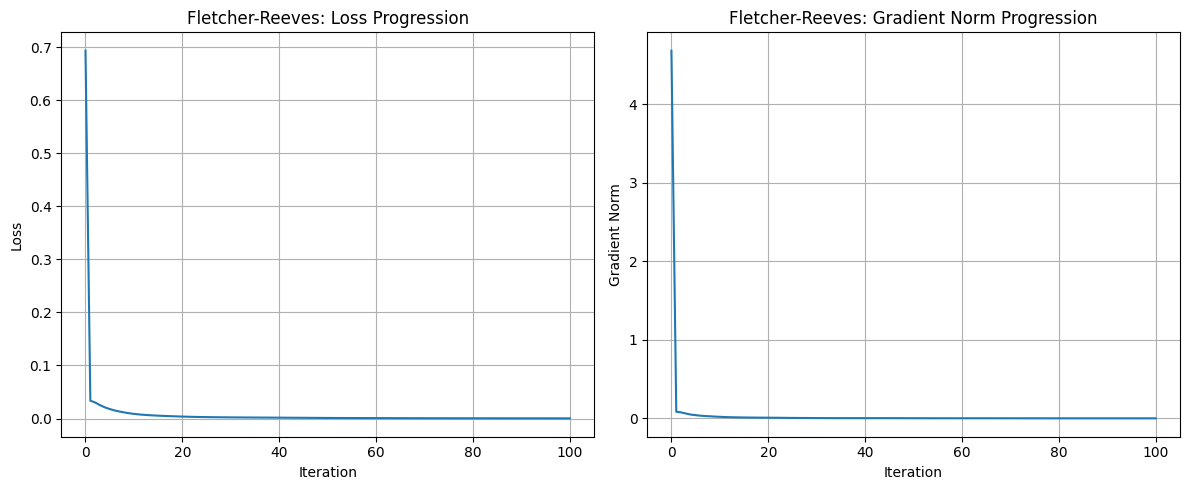


Training using Polak-Ribiere:
Polak-Ribiere Train Loss: 0.003189498558411449
Polak-Ribiere Test Accuracy: 0.9986468200270636
Time taken: 2.5118 seconds


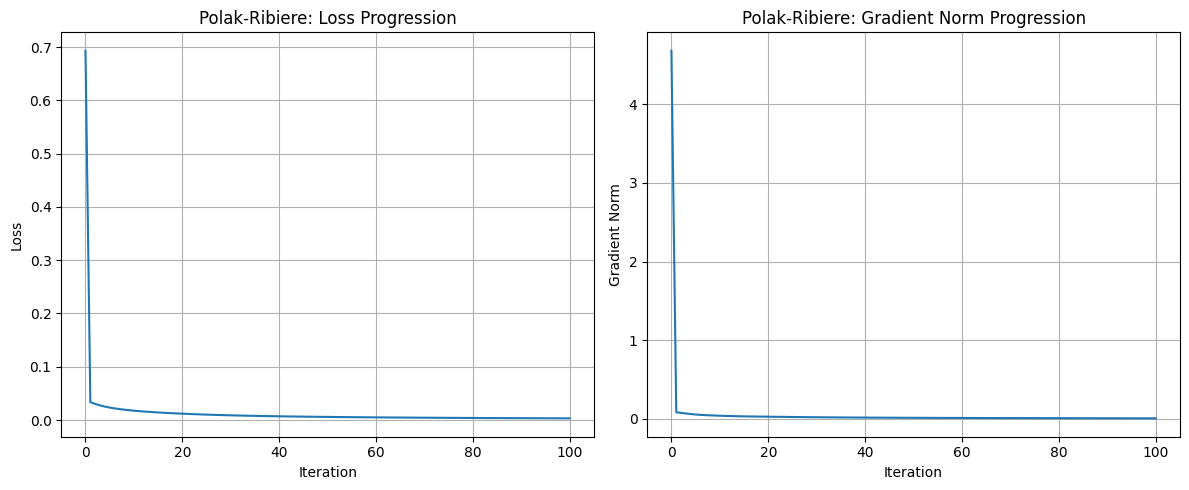


Training using L-BFGS:
L-BFGS Train Loss: 2.0344558559216543e-07
L-BFGS Test Accuracy: 0.9993234100135318
Time taken: 1.0874 seconds


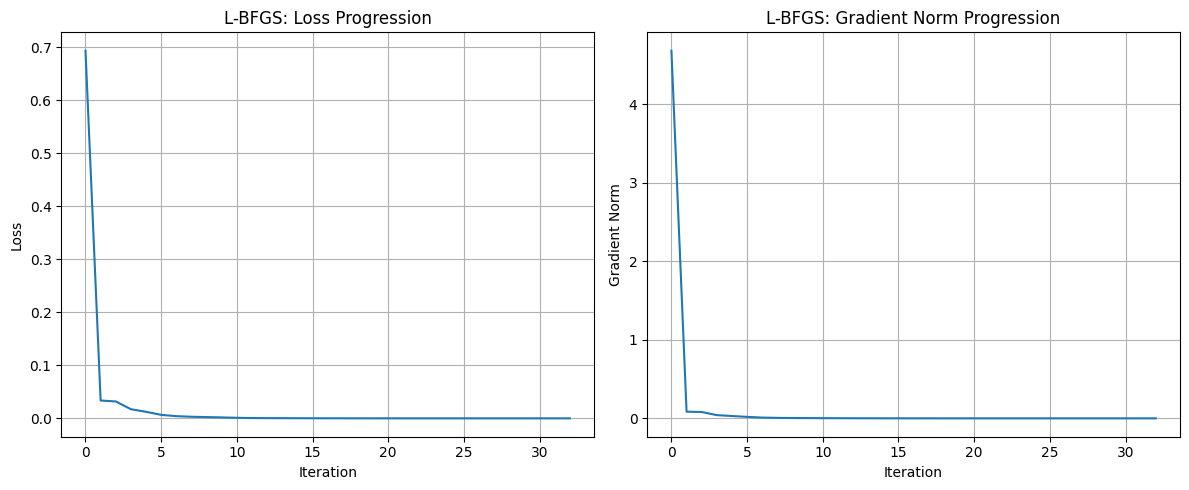


Using initial alpha: 1.0
Training using Fletcher-Reeves:
Fletcher-Reeves Train Loss: 0.0001268975808785463
Fletcher-Reeves Test Accuracy: 0.9979702300405954
Time taken: 2.6281 seconds


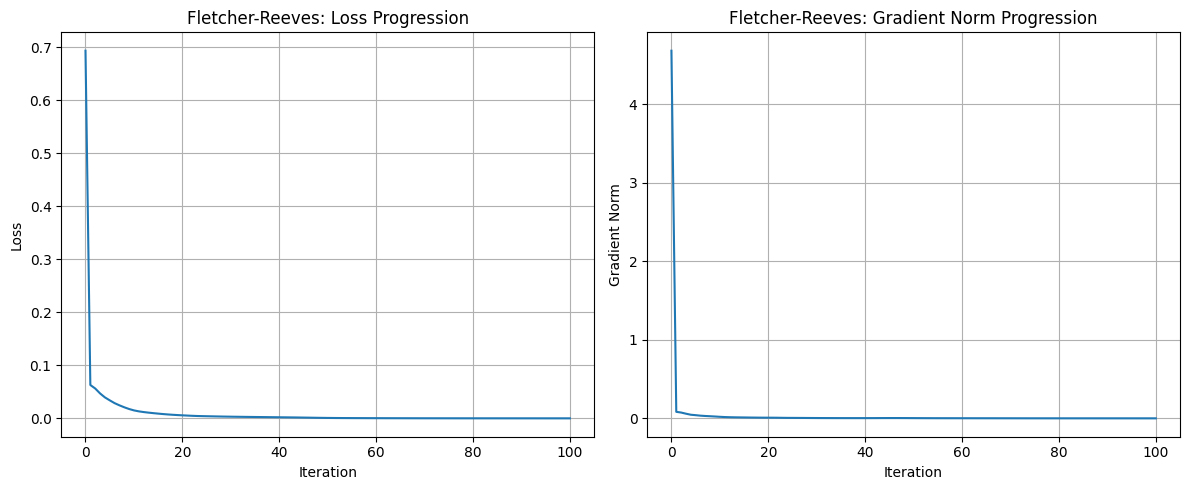


Training using Polak-Ribiere:
Polak-Ribiere Train Loss: 0.004641677190996914
Polak-Ribiere Test Accuracy: 0.9986468200270636
Time taken: 2.5494 seconds


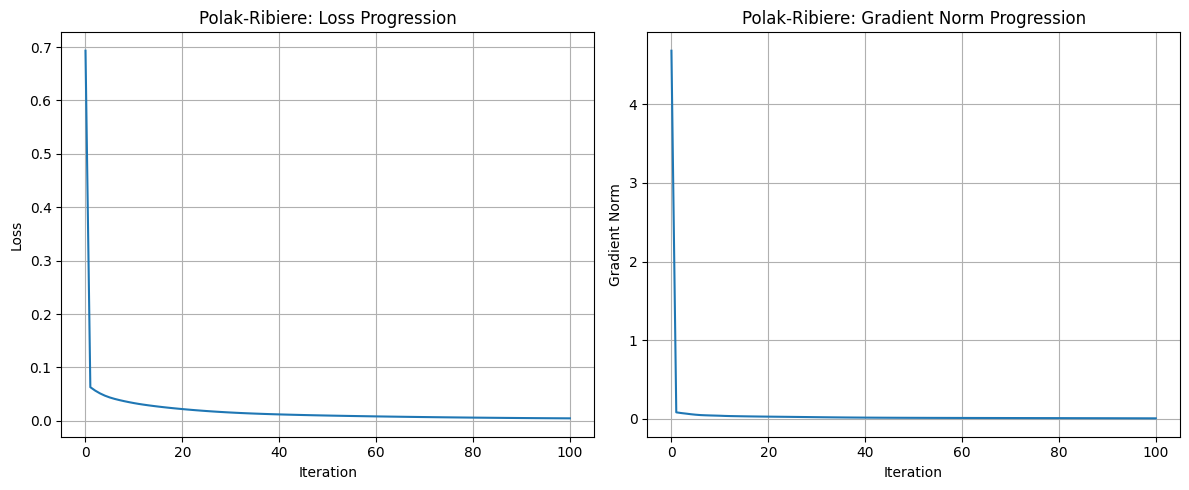


Training using L-BFGS:
L-BFGS Train Loss: 1.1837282513989708e-07
L-BFGS Test Accuracy: 0.9989851150202977
Time taken: 1.4493 seconds


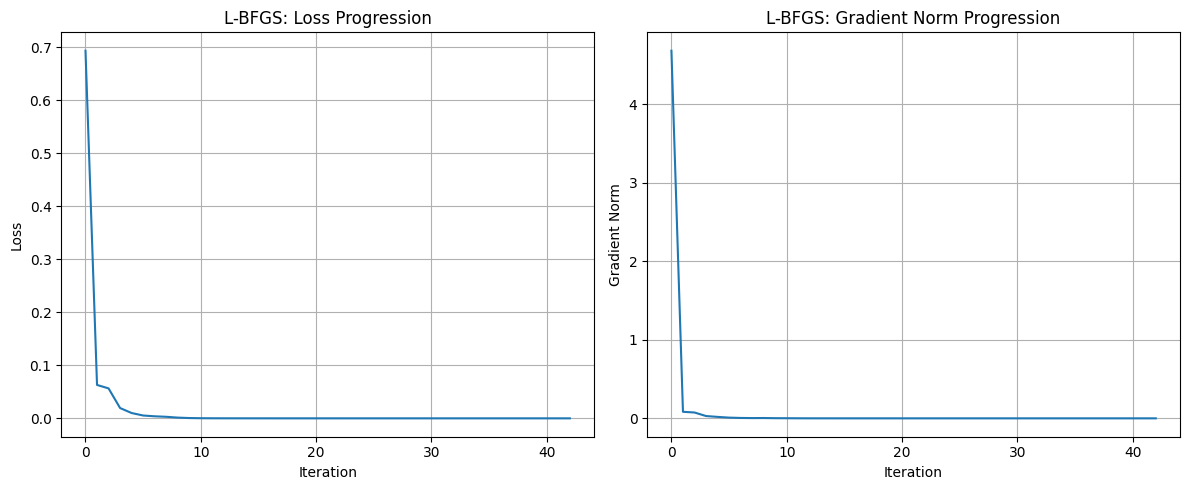


Using initial alpha: 5.0
Training using Fletcher-Reeves:
Fletcher-Reeves Train Loss: 1.0458610507698566e-05
Fletcher-Reeves Test Accuracy: 0.9976319350473613
Time taken: 2.5518 seconds


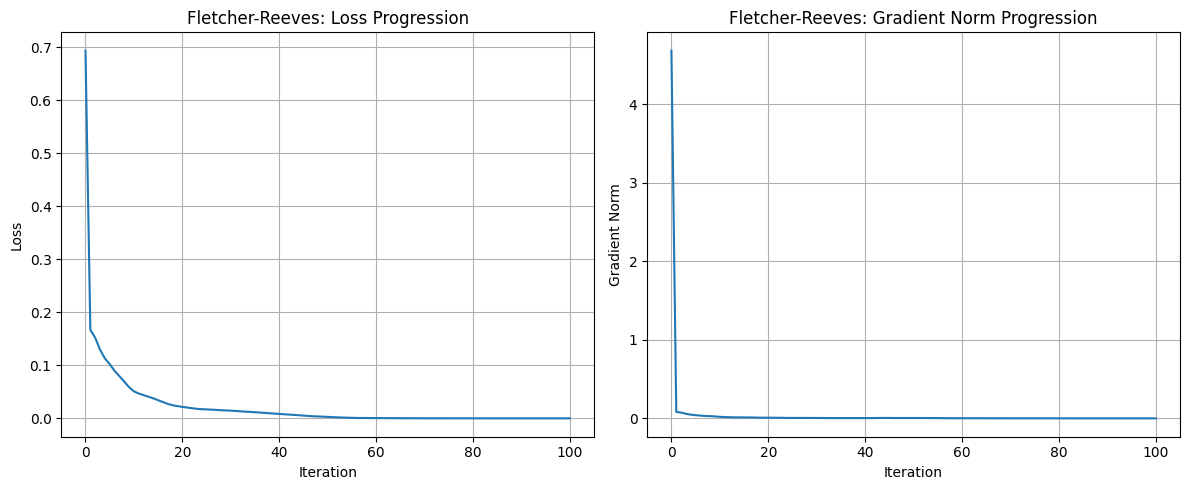


Training using Polak-Ribiere:
Polak-Ribiere Train Loss: 0.01864124716105923
Polak-Ribiere Test Accuracy: 0.9986468200270636
Time taken: 3.1640 seconds


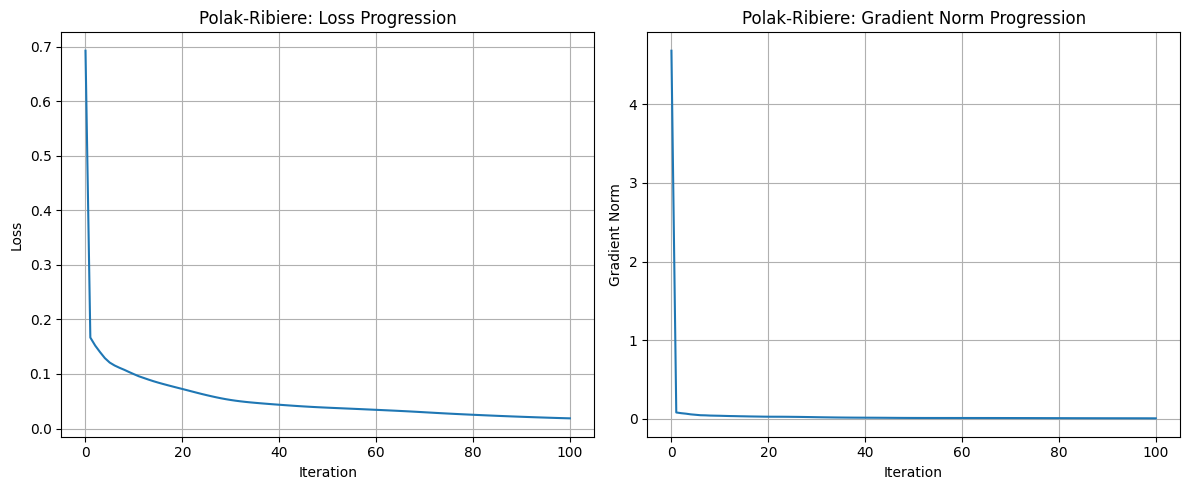


Training using L-BFGS:


/tmp/ipykernel_30/3759295351.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_30/3759295351.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_30/3759295351.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_30/3759295351.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_30/3759295351.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_30/3759295351.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_30/3759295351.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_30/3759295351.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_30/3759295351.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipykernel_30/3

L-BFGS Train Loss: 8.818563322036899e-08
L-BFGS Test Accuracy: 0.9979702300405954
Time taken: 1.1009 seconds


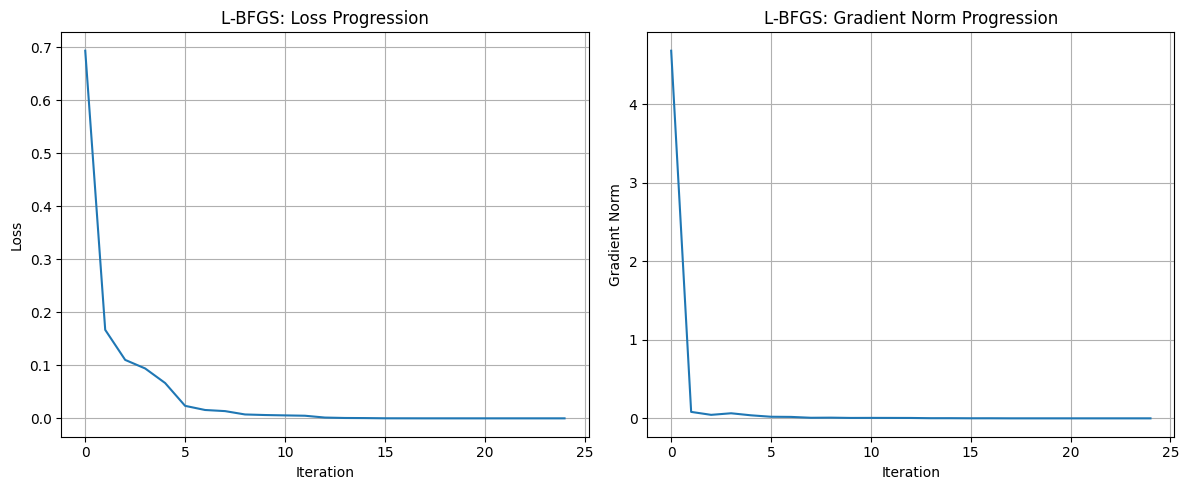

In [ ]:
# Set different initial alpha values
alpha_values = [0.1, 0.5, 1.0, 5.0]

# Store results
results = []

for initial_alpha in alpha_values:
    print(f"\nUsing initial alpha: {initial_alpha}")

    # Update the backtracking function to start with different alphas
    def backtracking_line_search(w, b, X, y, dw, db, alpha=initial_alpha, beta=0.5, c=1e-4):
        loss = loss_function(w, b, X, y)
        while True:
            w_new = w - alpha * dw
            b_new = b - alpha * db
            new_loss = loss_function(w_new, b_new, X, y)

            if new_loss <= loss - c * alpha * (np.linalg.norm(dw)**2 + db**2):
                break
            alpha *= beta

        return alpha

    # Measure time and train Fletcher-Reeves
    print("Training using Fletcher-Reeves:")
    start_time = time.time()
    w_fr, b_fr, losses_fr, grad_norms_fr = fletcher_reeves(X_train, y_train)
    end_time = time.time()
    y_pred_fr = predict(w_fr, b_fr, X_test)
    acc_fr = accuracy(y_test, y_pred_fr)
    time_fr = end_time - start_time
    print(f"Fletcher-Reeves Train Loss: {losses_fr[-1]}")
    print(f"Fletcher-Reeves Test Accuracy: {acc_fr}")
    print(f"Time taken: {time_fr:.4f} seconds")
    plot_results("Fletcher-Reeves", losses_fr, grad_norms_fr)

    # Measure time and train Polak-Ribiere
    print("\nTraining using Polak-Ribiere:")
    start_time = time.time()
    w_pr, b_pr, losses_pr, grad_norms_pr = polak_ribiere(X_train, y_train)
    end_time = time.time()
    y_pred_pr = predict(w_pr, b_pr, X_test)
    acc_pr = accuracy(y_test, y_pred_pr)
    time_pr = end_time - start_time
    print(f"Polak-Ribiere Train Loss: {losses_pr[-1]}")
    print(f"Polak-Ribiere Test Accuracy: {acc_pr}")
    print(f"Time taken: {time_pr:.4f} seconds")
    plot_results("Polak-Ribiere", losses_pr, grad_norms_pr)

    # Measure time and train L-BFGS
    print("\nTraining using L-BFGS:")
    start_time = time.time()
    w_lbfgs, b_lbfgs, losses_lbfgs, grad_norms_lbfgs = lbfgs_b(X_train, y_train, initial_alpha)
    end_time = time.time()
    y_pred_lbfgs = predict(w_lbfgs, b_lbfgs, X_test)
    acc_lbfgs = accuracy(y_test, y_pred_lbfgs)
    time_lbfgs = end_time - start_time
    print(f"L-BFGS Train Loss: {losses_lbfgs[-1]}")
    print(f"L-BFGS Test Accuracy: {acc_lbfgs}")
    print(f"Time taken: {time_lbfgs:.4f} seconds")
    plot_results("L-BFGS", losses_lbfgs, grad_norms_lbfgs)

    # Store the results
    results.append({
        "alpha": initial_alpha,
        "FR Accuracy": acc_fr,
        "FR Loss": losses_fr[-1],
        "FR Time (s)": time_fr,
        "PR Accuracy": acc_pr,
        "PR Loss": losses_pr[-1],
        "PR Time (s)": time_pr,
        "L-BFGS Accuracy": acc_lbfgs,
        "L-BFGS Loss": losses_lbfgs[-1],
        "L-BFGS Time (s)": time_lbfgs
    })


## Step 9: Performance Comparison

* Results are stored in a pandas DataFrame.

* The table displays:

    * Accuracy, final loss, and time for each method and α0.

* Provides a comparative overview of the optimization methods.

In [ ]:
# Display the results
import pandas as pd

df_results = pd.DataFrame(results)
print("\nComparison of Models' Performances for Different Alpha Values:")
print(df_results)



Comparison of Models' Performances for Different Alpha Values:
   alpha  FR Accuracy   FR Loss  FR Time (s)  PR Accuracy   PR Loss  \
0    0.1     0.999323  0.001334     2.754761     0.998985  0.006738   
1    0.5     0.998647  0.000362     2.565156     0.998647  0.003189   
2    1.0     0.997970  0.000127     2.628061     0.998647  0.004642   
3    5.0     0.997632  0.000010     2.551825     0.998647  0.018641   

   PR Time (s)  L-BFGS Accuracy   L-BFGS Loss  L-BFGS Time (s)  
0     2.532929         0.999323  5.144374e-06         3.396426  
1     2.511845         0.999323  2.034456e-07         1.087385  
2     2.549369         0.998985  1.183728e-07         1.449259  
3     3.163962         0.997970  8.818563e-08         1.100942  
